In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, ToPILImage


In [3]:
# Loads CIFAR10 into training_data
# Filepath = root, training indicator true, downloads if not available
# Option to transform to 3d tensors
training_data = datasets.CIFAR10(
    root = ".data",
    train = True,
    download = True,
    transform = ToTensor(),
    #target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)


# Loads CIFAR10 into testing_data
# Filepath = root, training indicator false, downloads if not available
# Option to transform to 3d tensors
testing_data = datasets.CIFAR10(
    root = ".data",
    train = False,
    download = True,
    transform = ToTensor(),
    #target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting .data/cifar-10-python.tar.gz to .data
Files already downloaded and verified


In [4]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [5]:
# Provides a dictionary for mapping label id to label text
labels_map = (
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
)

In [6]:
# Function to display training data
def display_training(size):
    figure = plt.figure(figsize=(8,8))
    cols, rows = size, size
    for i in range(1, cols * rows + 1):
        random_index = np.random.randint(len(training_data))
        img, label = training_data[random_index]
        plt.subplot(rows, cols, i)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img, cmap=plt.cm.binary)
        plt.xlabel(labels_map[label])
    plt.show()
#display_training(4)

In [7]:
# Loads data sets into DataLoader for batch processing
train_dataloader = DataLoader(training_data, batch_size=4, shuffle=True, num_workers = 2)
test_dataloader = DataLoader(testing_data, batch_size=4, shuffle=True, num_workers = 2)

Feature batch shape: torch.Size([4, 3, 32, 32])
Labels batch shape: torch.Size([4])
Label: cat


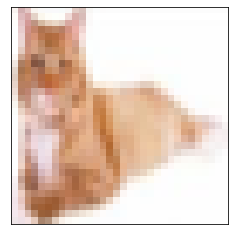

In [8]:
# Iterating through DataLoader
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]
label = train_labels[0]
plt.imshow(ToPILImage()(img), cmap="gray")
plt.xticks([])
plt.yticks([])
print(f"Label: {labels_map[train_labels[0]]}")
plt.show()

In [11]:
#Set up CNN
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

if train_on_gpu:
    net.cuda()


In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Epoch: 1 	Training Loss: 1.848732 	Validation Loss: 1.583952
Validation loss decreased (inf --> 1.583952).  Saving model ...
Epoch: 2 	Training Loss: 1.466371 	Validation Loss: 1.400408
Validation loss decreased (1.583952 --> 1.400408).  Saving model ...
Epoch: 3 	Training Loss: 1.331689 	Validation Loss: 1.295254
Validation loss decreased (1.400408 --> 1.295254).  Saving model ...
Epoch: 4 	Training Loss: 1.238497 	Validation Loss: 1.275841
Validation loss decreased (1.295254 --> 1.275841).  Saving model ...
Epoch: 5 	Training Loss: 1.164809 	Validation Loss: 1.209378
Validation loss decreased (1.275841 --> 1.209378).  Saving model ...
Epoch: 6 	Training Loss: 1.110322 	Validation Loss: 1.177450
Validation loss decreased (1.209378 --> 1.177450).  Saving model ...
Epoch: 7 	Training Loss: 1.064174 	Validation Loss: 1.163533
Validation loss decreased (1.177450 --> 1.163533).  Saving model ...
Epoch: 8 	Training Loss: 1.020204 	Validation Loss: 1.172303
Epoch: 9 	Training Loss: 0.985678 

ValueError: ignored

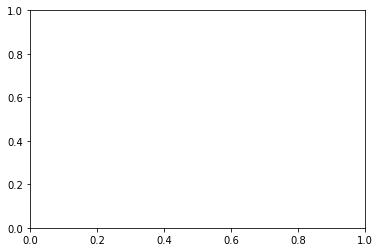

In [14]:
from typing import NewType
# number of epochs to train the model
n_epochs = 30
#List to store loss to visualize
train_losslist = []
valid_losslist = []
valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    net.train()
    for data, target in train_dataloader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = net(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    net.eval()
    for data, target in test_dataloader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = net(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_dataloader.dataset)
    valid_loss = valid_loss/len(test_dataloader.dataset)
    train_losslist.append(train_loss)
    #valid_losslist.append(valid_loss)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(net.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss


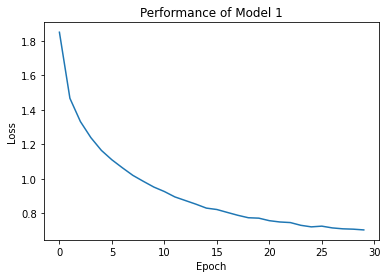

In [25]:
plt.plot([*range(n_epochs)], train_losslist)
#plt.plot([*range(n_epochs)], valid_losslist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Performance of Model 1")
plt.show()

In [17]:
#load best model state
net.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

In [19]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

net.eval()
# iterate over test data
for data, target in test_dataloader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = net(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(4):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_dataloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            labels_map[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (labels_map[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 1.163084

Test Accuracy of airplane: 70% (709/1000)
Test Accuracy of automobile: 65% (655/1000)
Test Accuracy of  bird: 47% (472/1000)
Test Accuracy of   cat: 46% (462/1000)
Test Accuracy of  deer: 55% (556/1000)
Test Accuracy of   dog: 38% (386/1000)
Test Accuracy of  frog: 72% (723/1000)
Test Accuracy of horse: 60% (606/1000)
Test Accuracy of  ship: 79% (795/1000)
Test Accuracy of truck: 63% (635/1000)

Test Accuracy (Overall): 59% (5999/10000)
